In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from LSsurf.smooth_xytb_fit_aug import smooth_xytb_fit_aug
from LSsurf.match_priors import match_prior_dz
import pointCollection as pc

In [9]:
%matplotlib notebook

In [24]:
# define the domain's width in x, y, and time
W={'x':1.e4,'y':1.e4,'t':12}
# define the grid center:
ctr={'x':0., 'y':0., 't':0.}
# define the grid spacing
p_spacing={'z0':100, 'dz':1000, 'dt':0.25}

In [25]:
x0=np.arange(-W['x']/2, W['x']/2+p_spacing['dz'], p_spacing['dz'])
t0=np.arange(-W['t']/2, W['t']/2+p_spacing['dt'])
lambda_x=5000
prior_amp=10
prior_sigma=1

xp, yp, tp=np.meshgrid(x0+W['x']/2, x0, t0)

Dg=pc.grid.data().from_dict({'x':xp[0,:,0].ravel(), 'y':x0,
                             'dz':(tp-t0[0])/W['t']*prior_amp*np.cos(2*np.pi*yp/lambda_x),
                             'time':t0, 'sigma_dz':np.zeros_like(xp)+prior_sigma})

Dg.to_h5('match_dz_data.h5', group='dz', replace=True)


In [26]:
#Define a minimal dataset (so that the 'data' variable is not empty)
y=np.arange(-W['y']/2, W['y']/2+100, 1000)
lambda_x=2000
data_sigma=100
D=pc.data().from_dict({'x':np.zeros_like(y)-W['x']/2+1000, 'y':y,'z':np.zeros_like(y),
                       'time':np.zeros_like(y)-0.5, 'sigma':np.zeros_like(y)+data_sigma})
# To ensure a time-constant simulation, replicate the data at times -0.5 and 0.5:
data=pc.data().from_list([D, D.copy().assign({'time':np.zeros_like(y)+0.5})])


<IPython.core.display.Javascript object>


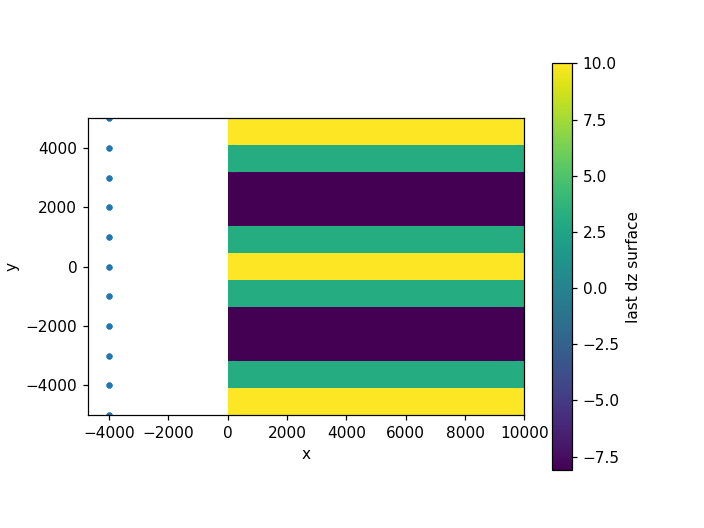

Text(0, 0.5, 'y')

In [27]:
plt.figure()
plt.imshow(Dg.dz[:,:,-1], extent=Dg.extent)
plt.plot(data.x, data.y,'.')
plt.colorbar(label='last dz surface')
plt.xlabel('x')
plt.ylabel('y')

In [28]:
E_d3zdx2dt=0.001
E_d2z0dx2=0.01
E_d2zdt2=4000

data_gap_scale=5000
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

prior_args={'filenames':['match_dz_data.h5']}

m_spacing={'z0':100, 'dz':1000, 'dt':0.25}
ref_epoch=np.ceil(W['t']/m_spacing['dt']/2.)

# run the fit
S=smooth_xytb_fit_aug(data=data, ctr=ctr, W=W, spacing=m_spacing, E_RMS=E_RMS,
                 reference_epoch=ref_epoch, compute_E=True,
                 max_iterations=1, prior_args=prior_args,
                 VERBOSE=True,
                 dzdt_lags=[1])


[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
initial: 21:
starting qr solve for iteration 0 at Wed Dec 15 13:58:31 2021
found 22 in TSE, sigma_extra_pre = nan, sigma_extra=0.000,  dt=  2
Starting uncertainty calculation
	Uncertainty propagation took 39.29 seconds


<IPython.core.display.Javascript object>


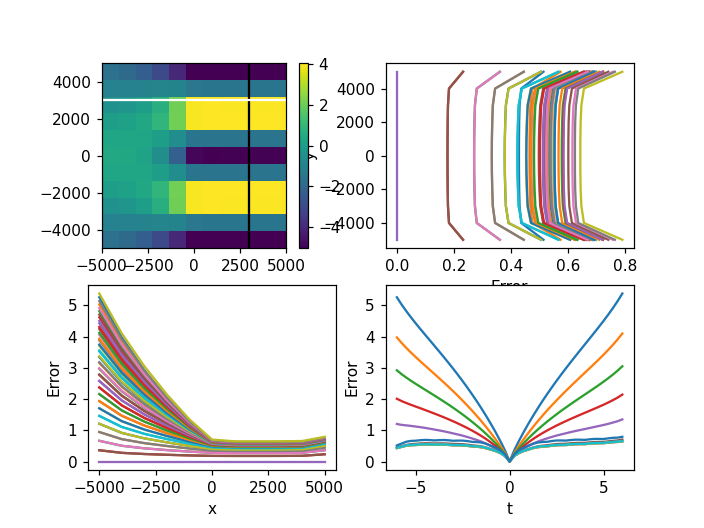

Text(0, 0.5, 'Error')

In [29]:
hfig, hax=plt.subplots(2, 2); hax=hax.ravel()
hi=hax[0].imshow(S['m']['dz'].dz[:,:,0], extent=S['m']['dz'].extent); plt.colorbar(mappable=hi, ax=hax[0])
hax[0].plot(S['E']['sigma_dz'].x[-3]+np.zeros(S['E']['sigma_dz'].shape[0]), S['E']['sigma_dz'].y, 'k')
hax[0].plot(S['E']['sigma_dz'].x, S['E']['sigma_dz'].y[-3]+np.zeros(S['E']['sigma_dz'].shape[1]), 'w')

hax[1].plot(S['E']['sigma_dz'].sigma_dz[:, -3, :], S['E']['sigma_dz'].y); hax[1].set_xlabel('Error'); hax[1].set_ylabel('y')
hax[2].plot(S['E']['sigma_dz'].x, S['E']['sigma_dz'].sigma_dz[-3, :, :]); hax[2].set_ylabel('Error'); hax[2].set_xlabel('x')
hax[3].plot(S['E']['sigma_dz'].time, S['E']['sigma_dz'].sigma_dz[-3,:,:].T)
hax[3].set_xlabel('t'); hax[3].set_ylabel('Error')



In [30]:
t_ind = np.flatnonzero(S['E']['sigma_dz'].time==2)
x_ind = np.flatnonzero(S['E']['sigma_dz'].x==3000)
y_ind = np.flatnonzero(S['E']['sigma_dz'].y==0)

S['E']['sigma_dz'].sigma_dz[y_ind, x_ind, t_ind]


array([0.48138787])

In [34]:
S_dict_sigma={}
for this_sigma_prior in [0.01, 0.05, 0.1, 0.5, 1., 5., 10.]:
    print(this_sigma_prior)
    D_prior=pc.grid.data().from_dict({'x':xp[0,:,0].ravel(), 'y':x0,
                             'dz':(tp-t0[0])/W['t']*prior_amp*np.cos(2*np.pi*yp/lambda_x),
                             'time':t0, 'sigma_dz':np.zeros_like(xp)+this_sigma_prior})
    D_prior.to_h5('match_dz_data.h5', group='dz', replace=True)
    S_dict_sigma[this_sigma_prior]=\
        smooth_xytb_fit_aug(data=data, ctr=ctr, W=W, spacing=m_spacing, E_RMS=E_RMS,
                 reference_epoch=ref_epoch, compute_E=True,
                 max_iterations=1, prior_args=prior_args,
                 VERBOSE=False,
                 dzdt_lags=[1])    



0.01
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
0.05
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
0.1
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
0.5
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
1.0
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
5.0
[array([-5000.,  5000.]), array([    0., 10000.]), array([-6.,  6.])]
grid bds are:[array([-5000.,  5000.]), array([-5000.,  5000.]), array([-6.,  6.])]
10.0
[array([-5000.,  5000.]), array([    0., 10000.]), 

<IPython.core.display.Javascript object>


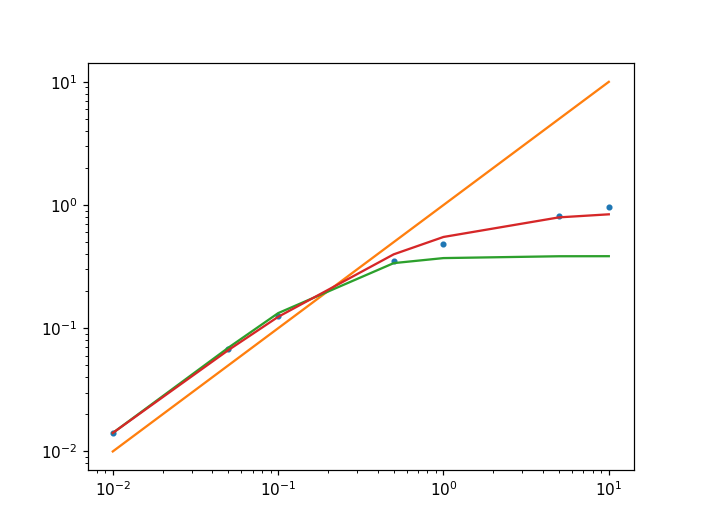

In [54]:
sigma_prior_vals=np.array(list(S_dict_sigma.keys()))
sigma_dz_vals=sigma_prior_vals*np.NaN

for ii, key in enumerate(sigma_prior_vals):
    Si =S_dict_sigma[key]

    t_ind = np.flatnonzero(Si['E']['sigma_dz'].time==2)
    x_ind = np.flatnonzero(Si['E']['sigma_dz'].x==3000)
    y_ind = np.flatnonzero(Si['E']['sigma_dz'].y==0)

    sigma_dz_vals[ii] = Si['E']['sigma_dz'].sigma_dz[y_ind, x_ind, t_ind]

plt.figure(); plt.loglog(sigma_prior_vals, sigma_dz_vals,'.')
plt.loglog(sigma_prior_vals, sigma_prior_vals)


Assume that $\sigma$ values are equal to the error-weighted sum of two components: 
$$sigma^{-2} = (A \sigma_d)^{-2} + \sigma_{bg}^{-2}$$


In [ ]:
G=np.c_[sigma_prior_vals**-2, np.ones_like(sigma_prior_vals)]
m=np.linalg.inv(G.T.dot(G)).dot(G.T).dot(sigma_dz_vals**-2)

minv2=m**-2
plt.plot(sigma_prior_vals, ((minv2[0]*sigma_prior_vals)**-2+minv2[1]**-1)**-2, label='inverse-squared weight')

Assume that $\sigma$ values are equal to the error-weighted sum of two components: 
$$sigma^{-1} = (A \sigma_d)^{-1} + \sigma_{bg}^{-1}$$


In [56]:
G=np.c_[sigma_prior_vals**-1, np.ones_like(sigma_prior_vals)]
m=np.linalg.inv(G.T.dot(G)).dot(G.T).dot(sigma_dz_vals**-1)

minv=m**-1
plt.plot(sigma_prior_vals, ((minv[0]*sigma_prior_vals)**-1+minv[1]**-1)**-1, label='inverse weight')

In [1]:
plt.legend()

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


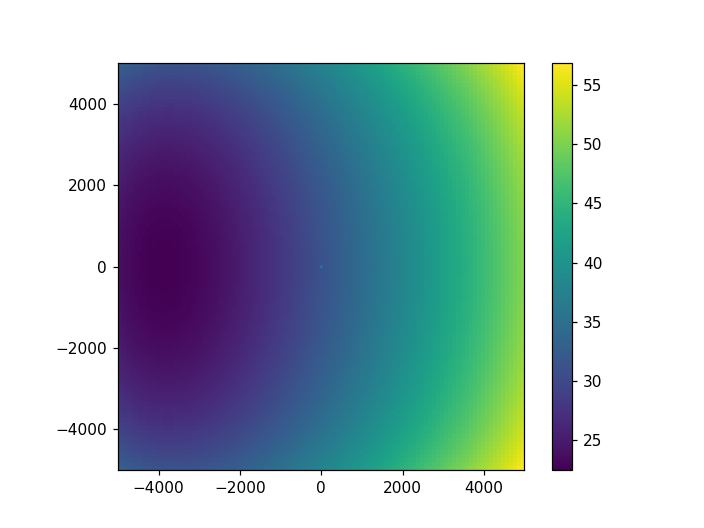

In [47]:
plt.figure(); S['E']['sigma_z0'].show(field='sigma_z0'); plt.colorbar()